### Exploratory Data Analysis of Unemployment rates, COVID-19 Community Transmission, and Current Hospital Capacity Estimates at the U.S. County Level 

By ***Juan Vega*** 

This notebook will conduct exploratory data analysis to explore the relationship between the following variables and the number of deaths per capita due to COVID-19 in U.S. counties:
* Unemployment rate from the [Bureau of Labor Statistics](https://www.bls.gov/lau/)
* Community transmission level (low, moderate, substantial, high) from the [Center for Disease Control (CDC)](https://data.cdc.gov/Public-Health-Surveillance/United-States-COVID-19-County-Level-of-Community-T/8396-v7yb)
* Current Hospital Capacity Estimates from the [CDC](https://www.cdc.gov/nhsn/covid19/report-patient-impact.html)

#### Import all required libraries and data sources.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go

#### The `merged_dataset` source  includes all relevant features from multiple data sets referenced in the `README.md` in project repository.
In the next steps:
* Identify the number of missing values per column
* Check the data types of the features in the merged data set
* Produce a correlation heatmap to evaluate the correlations of these features with the target variable or the death rate per capita per 100,000 population (death rate)
* Explore the relationship between the death rate and the number of cases per capita per 10,000 population (cases per capita) and additional features available in the data set

In [2]:
covid_cases = pd.read_csv('./Data/merged_dataset.csv')

In [3]:
covid_cases.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,SVI__B,SVI__C,SVI__D,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop,minority_group_total
0,Autauga,1001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,1.0,0.0,0.0,27092,28777,42607,11237,656,58,11237
1,Baldwin,1003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,0.0,0.0,0.0,108247,114987,195198,19593,2380,154,19593
2,Barbour,1005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,0.0,0.0,1.0,13064,11622,12134,11906,116,52,11906
3,Bibb,1007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,0.0,1.0,0.0,11929,10465,17191,4763,48,26,4763
4,Blount,1009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,1.0,0.0,0.0,28472,29354,55412,978,185,67,978


The dataset contains 3,133 observations and 54 columns.

In [4]:
covid_cases.shape

(3133, 54)

Some of the features in this data set contain a high proportion of features with missing values ~ 22% (703/3133). However these features are not the focus of this EDA task, so they will be bypassed. 

In [5]:
covid_cases.isnull().sum()[covid_cases.isnull().sum()>0].sort_values(ascending=False)

inpatient_beds_used_covid_7_day_sum                            702
staffed_icu_adult_patients_confirmed_covid_7_day_sum           702
total_staffed_adult_icu_beds_7_day_sum                         702
total_icu_beds_7_day_sum                                       702
inpatient_beds_7_day_sum                                       702
total_adult_patients_hospitalized_confirmed_covid_7_day_sum    702
inpatient_beds_used_7_day_sum                                  702
total_beds_7_day_sum                                           702
icu_beds_used_7_day_sum                                        702
total_votes                                                     26
biden_votes                                                     25
trump_votes                                                     25
med_per_test_results_positive                                   18
county_vac_pct                                                   1
SVI__A                                                        

#### All columns are of the expected data types

In [6]:
covid_cases.dtypes

county                                                          object
county_fips_code                                                 int64
cases                                                            int64
deaths                                                         float64
stname                                                          object
ctyname                                                         object
tot_pop                                                        float64
deaths_per_hun_thou                                            float64
cnty_name                                                       object
unemployment_rate                                              float64
med_cases_per_100k_change                                      float64
med_per_test_results_positive                                  float64
transmission_level_high                                        float64
transmission_level_low                                         float64
transm

The correlation heatmaps below plot the relationship between features in the data set and the death rate and number of cases per capita:
* The features that are more strongly and positive correlated with a higher death rate per capita are:
    * A high level of social vulnerability as measured by the `D` category of the CDC's Social Vulnerability Index (SVI), according to an official from the CDC. For more information on the SVI, please see [this](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/pdf/SVI2018Documentation_01192022_1.pdf) documentation
    * A higher median number of new cases per 100,000 population over the last 7-day window across all reporting periods in 2020 and 2021
    * A higher percentage of a county's residents who report they never mask
    * A higher level of community transmission defined as the percentage of reporting periods that a county was classified as having a high or subtantial level of COVID-19 transmission
    * There does not appear to be a strong correlation between the unemployment rate and the death rate per capita. However exploring this feature is importnat to evaluate the impact of COVID-19 on local economic conditions
* The features that are more strongly and positively correlated with a higher COVID case rate are mostly the features mentioned in the previous bullet points

The death rate will be used as the target variable in this analysis as it is a comparable metric across all U.S. counties and is normalized by the population size.
    

In [7]:
def data_viz(feature,title,df):
    plt.figure(figsize=(5,10))
    plt.title(title)
    sns.heatmap(df.corr()[[feature]].sort_values(by=feature,ascending=False),
                vmin=-1,
                vmax=1,
                cmap='Blues',
                annot=True);

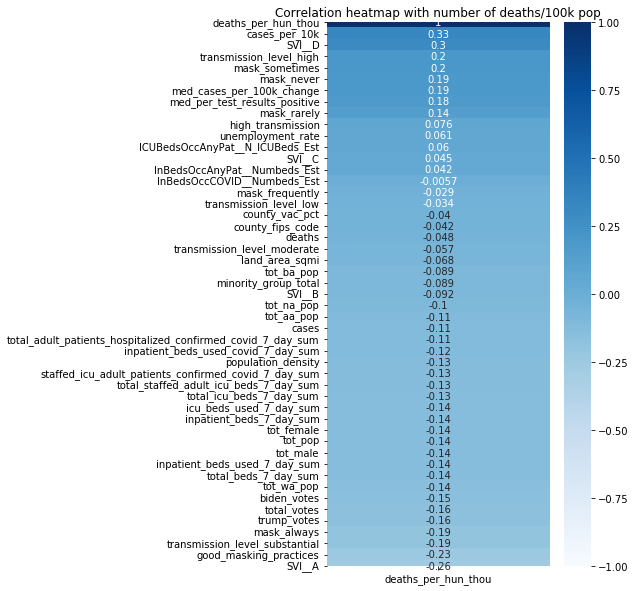

In [8]:
data_viz('deaths_per_hun_thou',
         'Correlation heatmap with number of deaths/100k pop',covid_cases)

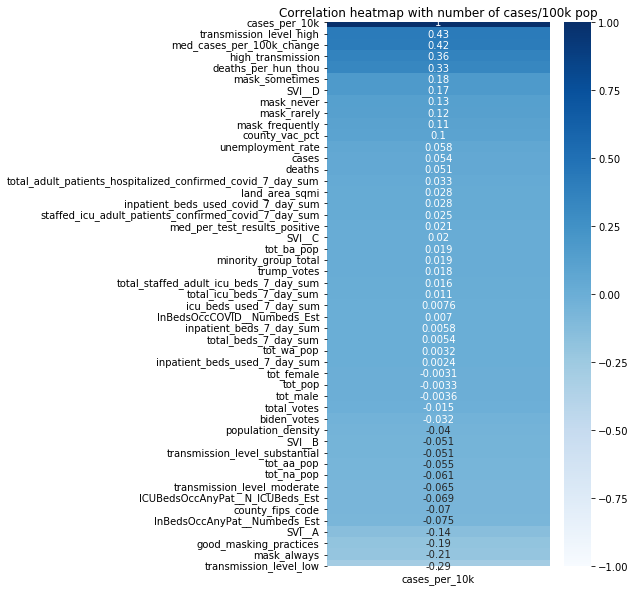

In [9]:
data_viz('cases_per_10k','Correlation heatmap with number of cases/100k pop',covid_cases)

# Unemployment

Overall, there does not appear to be a strong relationsip between the unemployment rate and the death rate per capita. And there does not appear to be a strong relationship between the unemployment rate and the number of cases per capita. This is likely because the unemployment rate in most counties has remained at around 10 percent or less and the federal government has provided a fiscal stimulus, the [CARES Act](https://home.treasury.gov/policy-issues/coronavirus), to prevent the economy going into a recession as a result of COVID-19.

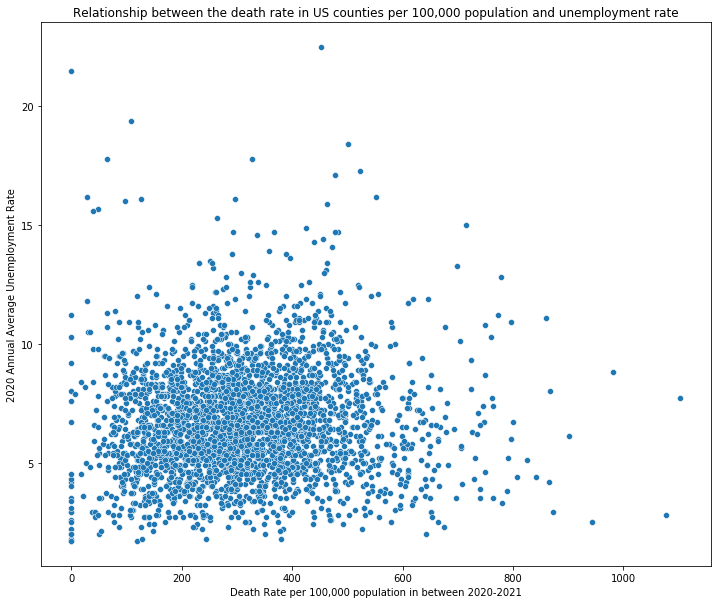

In [10]:
plt.figure(figsize=(12,10))
plt.title('Relationship between the death rate in US counties per 100,000 population and unemployment rate')
plt.ylabel('2020 Annual Average Unemployment Rate')
plt.xlabel('Death Rate per 100,000 population in between 2020-2021')
sns.scatterplot(data=covid_cases,y='unemployment_rate',x='deaths_per_hun_thou');

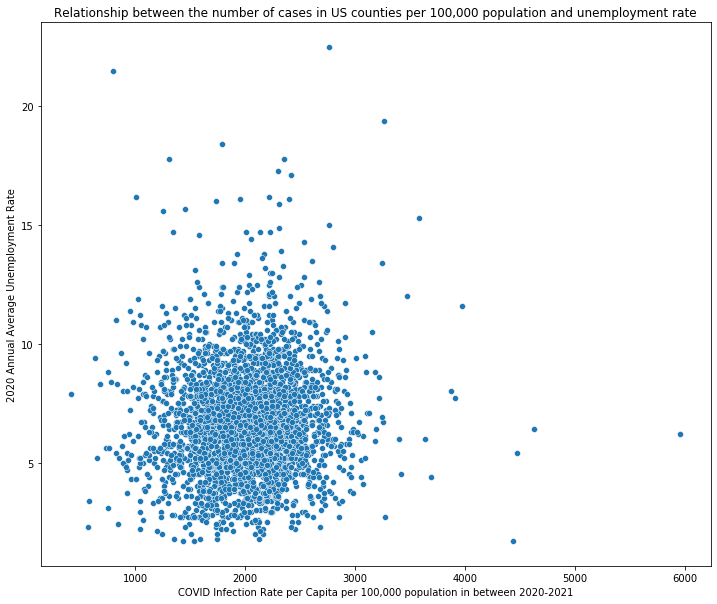

In [11]:
plt.figure(figsize=(12,10))
plt.title('Relationship between the number of cases in US counties per 100,000 population and unemployment rate')
plt.ylabel('2020 Annual Average Unemployment Rate')
plt.xlabel('COVID Infection Rate per Capita per 100,000 population in between 2020-2021')
sns.scatterplot(data=covid_cases,y='unemployment_rate',x='cases_per_10k');

### Community Transmissibility

It is expected that as there is a higher degree of community transmissibility, the virus should spread more rapidly, which may contribute to higher death rates due to COVID-19. However, the plots below show that there isn't a strong relationship between the degree of COVID-19 transmissibility by county and the death rate per capita, but there is a stronger relationship between a high degree of transmissibility and number of COVID-19 cases per capita. However, in some cases, as the degree of transmissibility increases, the death rate per capita increases. This relationship appears to be clearer among counties with a death rate per capita below 200.

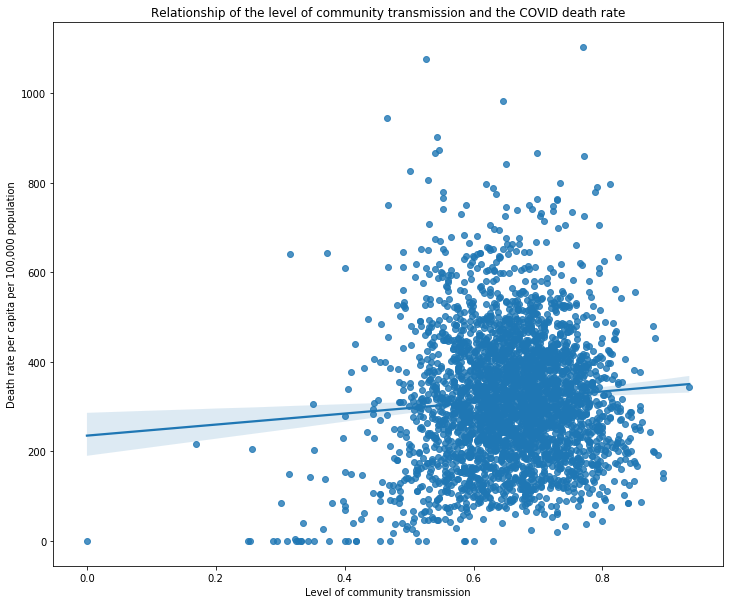

In [12]:
plt.figure(figsize=(12,10))
plt.title('Relationship of the level of community transmission and the COVID death rate')
sns.regplot(data=covid_cases,x='high_transmission',y='deaths_per_hun_thou')
plt.xlabel('Level of community transmission')
plt.ylabel('Death rate per capita per 100,000 population');

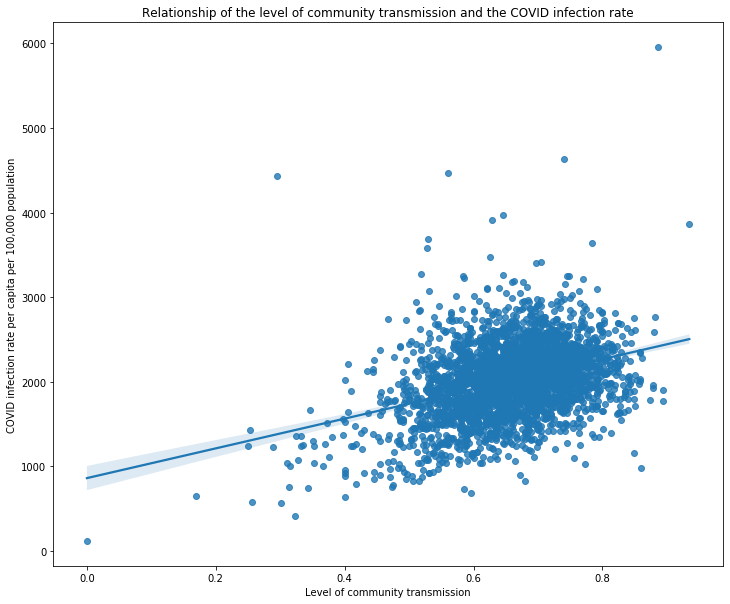

In [13]:
plt.figure(figsize=(12,10))
plt.title('Relationship of the level of community transmission and the COVID infection rate')
sns.regplot(data=covid_cases,x='high_transmission',y='cases_per_10k')
plt.xlabel('Level of community transmission')
plt.ylabel('COVID infection rate per capita per 100,000 population');

### Hospital Capacity
The data represented geographically below from the CDC's [Current Hospital Capacity Estimates](https://www.cdc.gov/nhsn/covid19/report-patient-impact.html) show that:
* Certain U.S. states have had disproportionately higher median shares of inpatient beds used, and inpatient beds for COVID-19 patients such as New York, Maryland, Massachusetts, and Illinois between 2020 and 2021.
* These states also have a disproportionately higher share of ICU beds used
* It is interesting to see that Georgia is a state with a high share of ICU bed occupancy, and is also a state with some of the highest median death rates from COVID-19 between 2020-2021

These maps were created using the [Plotly](https://plotly.com/python/choropleth-maps/) documentation on Choropleth maps.

In [14]:
hosp_capacity_states = covid_cases[['state','InBedsOccAnyPat__Numbeds_Est','InBedsOccCOVID__Numbeds_Est',
                                    'ICUBedsOccAnyPat__N_ICUBeds_Est']].drop_duplicates()

In [15]:
hosp_capacity_states.head()

,state,InBedsOccAnyPat__Numbeds_Est,InBedsOccCOVID__Numbeds_Est,ICUBedsOccAnyPat__N_ICUBeds_Est
0,AL,66.05,6.60,73.30
67,AK,54.95,1.55,59.70
92,AZ,64.10,8.20,53.75
107,AR,51.85,2.50,57.70
182,CA,59.45,6.40,63.30


In [16]:
figure = go.Figure(data=go.Choropleth(
    locations=hosp_capacity_states['state'],
    z = hosp_capacity_states['InBedsOccAnyPat__Numbeds_Est'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Hospital inpatient bed occupancy",
))

figure.update_layout(
    title_text = 'Hospital inpatient bed occupancy, percent estimate (percent of inpatient beds)',
    geo_scope='usa',
)

figure.show()

In [17]:
figure = go.Figure(data=go.Choropleth(
    locations=hosp_capacity_states['state'],
    z = hosp_capacity_states['InBedsOccCOVID__Numbeds_Est'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Percent of inpatient beds for COVID-19 patients",
))

figure.update_layout(
    title_text = 'Number of patients in an inpatient care location who have suspected or confirmed COVID-19',
    geo_scope='usa',
)

figure.show()

In [18]:
figure = go.Figure(data=go.Choropleth(
    locations=hosp_capacity_states['state'],
    z = hosp_capacity_states['ICUBedsOccAnyPat__N_ICUBeds_Est'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "ICU bed occupancy",
))

figure.update_layout(
    title_text = 'ICU bed occupancy, percent estimate (percent of ICU beds)',
    geo_scope='usa',
)

figure.show()

In [19]:
### Use JSON file from Plotly to locate every county on a map based on its FIPS code
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [20]:
figure = px.choropleth(covid_cases, geojson=counties, locations='county_fips_code', color='deaths_per_hun_thou',
                      color_continuous_scale='burgyl',
                      range_color=(0,covid_cases['deaths_per_hun_thou'].max()),
                      scope="usa",
                      labels={'deaths_per_hun_thou':'Deaths per capita per 100k population'},
                      hover_name='cnty_name')
figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
figure.show()

### Conclusions from EDA:
* The feature for a high level of transmission appears to be moderately correlated with a higher number of COVID-19 infections per capita and death rate per capita
* There does not appear to be a relationship between the unemployment rate and the death rate per capita and the COVID-19 infection rate, potentially due to the CARES Act [source](https://en.wikipedia.org/wiki/CARES_Act)
* Some states have disproportionately higher hospital inpatient bed occupancy for COVID-19 patients like IL, NY, and MD
* Some states like AL have a disproportionately higher ICU bed occupancy

Therefore, in a future modeling step, this project should consider predicting the the death rate using features such as the degree of COVID-19 transmission. State level features are less strong candidates because the unit of analysis is different (i.e., states vs. counties) but should still be considered in the modeling and analysis stage.